# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact
import localcider
from localcider.sequenceParameters import SequenceParameters



# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Load in Data

## 1.1 - Load in experimental data

    GFP_Nucleolus  GFP_Gpatch_pMK226  GFP_NKAPD1_pMK223  GFP_RP9_pMK224  \
0        0.617920           0.843088           2.007163        3.690067   
1        0.713604           1.000882           2.004326        3.890533   
2        0.664294           0.993676           2.059116        3.447600   
3        0.568151           0.960294           1.989442        2.871136   
4        0.583586           0.858971           2.000512        3.771955   
5        0.646613           0.823676           2.000837        3.828909   
6        0.696026           1.048529           2.419531        3.411682   
7        0.710557           0.760147           2.405094        3.053045   
8        0.616880           0.795735           2.430688        2.979818   
9        0.646735           1.080735           2.418656        2.874682   
10       0.709159           1.205588           2.076710        3.320500   
11       0.724480           0.948971           1.915385             NaN   
12       0.600628        

/home/research/kiersten.ruff/.local/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#dddddd'` for same effect.
  warnings.warn(msg, FutureWarning)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GFP_Nucleolus'),
  Text(1, 0, 'GFP_BRD7_pMK229'),
  Text(2, 0, 'GFP_NKAPD1_pMK223'),
  Text(3, 0, 'GFP_FCF1_pMK230'),
  Text(4, 0, 'GFP_RP9_pMK224')])

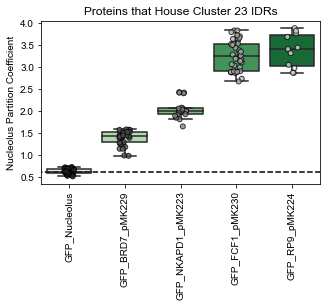

In [7]:
dfnuc=pd.read_excel('data/PC_Nucleolus_and_NS.xlsx',sheet_name='Compiled_Nucleolus')
#dfloc=dfloc.fillna('')
myconstructs=dfnuc.columns.tolist()

print(dfnuc)
print(myconstructs)

dfnuc_noGPATCH3=dfnuc.drop(columns=['GFP_Gpatch_pMK226','GFP_GPatch4_pMK232'])
print(dfnuc_noGPATCH3)

index_sort = dfnuc_noGPATCH3.median().sort_values().index
sorted_feats=index_sort.tolist()
dfnuc_noGPATCH3 = dfnuc_noGPATCH3[index_sort]

gfpmed=np.nanmedian(dfnuc_noGPATCH3['GFP_Nucleolus'].tolist())
plt.figure(figsize=(5,3))
plt.plot([-1,len(myconstructs)+1],[gfpmed,gfpmed],'--',color='#000000')
sbn.boxplot(dfnuc_noGPATCH3,palette='Greens',showfliers=False)
sbn.stripplot(dfnuc_noGPATCH3,color='#dddddd',size=5,linewidth=1, edgecolor='black', alpha=0.75)
plt.ylabel('Nucleolus Partition Coefficient')
plt.title('Proteins that House Cluster 23 IDRs')
plt.xticks(rotation=90) 

#plt.savefig('exp_localization/figures/cluster_23_nucleolus_PC.pdf', transparent=True, bbox_inches = "tight")


      GFP_NS  GFP_LUC7L2_pMK227  GFP_PRPF38B_pMK238  GFP_SNRN70_Trunc_pMK239  \
0   0.822487           5.770276            9.757462                11.019636   
1   0.754943           6.699379           11.443846                11.068545   
2   0.744704           6.024138           11.837154                10.686000   
3   0.751068           5.574138           11.158923                11.904727   
4   0.765754           6.142000           11.323692                11.330727   
5   0.792997           6.318966           11.597538                12.016727   
6   0.864264           6.402897           12.366231                12.074727   
7   0.853869           6.945862           12.654154                12.618364   
8   0.822452           5.835310           12.758692                11.188909   
9   0.755174           6.368069            7.978538                12.171273   
10  0.767863           5.714207            9.049231                11.916000   
11  0.790049           6.343655         

/home/research/kiersten.ruff/.local/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#dddddd'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Nuclear Speckles Partition Coefficient')

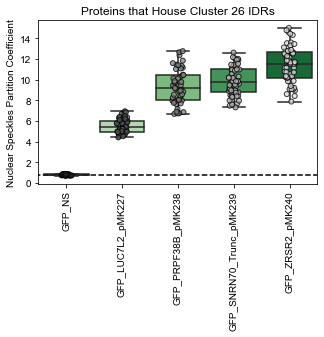

In [6]:
dfloc=pd.read_excel('data/PC_Nucleolus_and_NS.xlsx',sheet_name='Compiled_NS')
#dfloc=dfloc.fillna('')
myconstructs=dfloc.columns.tolist()

print(dfloc)
print(myconstructs)


index_sort = dfloc.median().sort_values().index
sorted_feats=index_sort.tolist()
dfloc = dfloc[index_sort]

gfpmed=np.nanmedian(dfloc['GFP_NS'].tolist())
plt.figure(figsize=(5,3))
plt.plot([-1,len(myconstructs)+1],[gfpmed,gfpmed],'--',color='#000000')
sbn.boxplot(dfloc,palette='Greens')
sbn.stripplot(dfloc,color='#dddddd',size=5,linewidth=1, edgecolor='black', alpha=0.75)
plt.xticks(rotation=90) 
plt.title('Proteins that House Cluster 26 IDRs')
plt.ylabel('Nuclear Speckles Partition Coefficient')

#plt.savefig('exp_localization/figures/cluster_26_nuclear_speckles_PC.pdf', transparent=True, bbox_inches = "tight")


    GFP_Nucleolus  GFP_Gpatch_pMK226  GFP_NKAPD1_pMK223  GFP_RP9_pMK224  \
0        0.617920           0.843088           2.007163        3.690067   
1        0.713604           1.000882           2.004326        3.890533   
2        0.664294           0.993676           2.059116        3.447600   
3        0.568151           0.960294           1.989442        2.871136   
4        0.583586           0.858971           2.000512        3.771955   
5        0.646613           0.823676           2.000837        3.828909   
6        0.696026           1.048529           2.419531        3.411682   
7        0.710557           0.760147           2.405094        3.053045   
8        0.616880           0.795735           2.430688        2.979818   
9        0.646735           1.080735           2.418656        2.874682   
10       0.709159           1.205588           2.076710        3.320500   
11       0.724480           0.948971           1.915385             NaN   
12       0.600628        

/home/research/kiersten.ruff/.local/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#dddddd'` for same effect.
  warnings.warn(msg, FutureWarning)
meta NOT subset; don't know how to subset; dropped


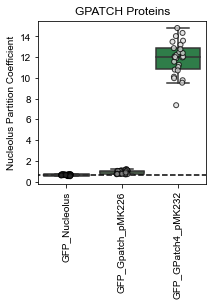

In [49]:
dfnuc=pd.read_excel('data/PC_Nucleolus_and_NS.xlsx',sheet_name='Compiled_Nucleolus')
#dfloc=dfloc.fillna('')
myconstructs=dfnuc.columns.tolist()

print(dfnuc)
print(myconstructs)

dfnuc_GPATCH=dfnuc.drop(columns=['GFP_NKAPD1_pMK223', 'GFP_RP9_pMK224', 'GFP_BRD7_pMK229', 'GFP_FCF1_pMK230'])
print(dfnuc_GPATCH)

index_sort = dfnuc_GPATCH.median().sort_values().index
sorted_feats=index_sort.tolist()
dfnuc_GPATCH = dfnuc_GPATCH[index_sort]

gfpmed=np.nanmedian(dfnuc_GPATCH['GFP_Nucleolus'].tolist())
plt.figure(figsize=(3,3))
plt.plot([-1,len(myconstructs)+1],[gfpmed,gfpmed],'--',color='#000000')
sbn.boxplot(dfnuc_GPATCH,palette='Greens',showfliers=False)
sbn.stripplot(dfnuc_GPATCH,color='#dddddd',size=5,linewidth=1, edgecolor='black', alpha=0.75)
plt.ylabel('Nucleolus Partition Coefficient')
plt.title('GPATCH Proteins')
plt.xticks(rotation=90) 

#plt.savefig('exp_localization/figures/GPATCH_proteins_nucleolus_PC.pdf', transparent=True, bbox_inches = "tight")
